# Predicting Shelter Cat Adoptions and Transfers 

In the [previous notebook analysis](https://aaronschlegel.me/exploratory-data-analysis-shelter-cat-outcomes-pandas-seaborn.html), we identified several likely candidate features and variables that could be significant in predicting a cat's outcome as it enters the shelter. Using that information and [scikit-learn](http://scikit-learn.org/stable/), we can train a machine learning model to predict if a cat will be adopted or transferred to a partner facility. For this first task, we are only interested in the adoption and transfer outcomes to see if our assumptions based on experience and the information we learned from the previous analysis align with predicted results. Adoptions and transfers represent over 90% of all the outcomes in the Austin Animal Center shelter system, therefore focusing on these outcomes and their more specific subtype outcomes and building a model to predict these outcomes is still quite valuable. 

This notebook will walk through preparing our data that was [feature engineered and cleaned in a previous notebook in the series](https://aaronschlegel.me/extraction-feature-engineering-aac-data-requests-pandas.html) for use with scikit-learn's machine learning models and functions, then use that data to find essential features that are useful in predicting the outcome of a shelter cat. We then fit a random forests model to predict the outcomes and perform cross-validation and other model validation procedures to test the performance of our model on held out data. Finally, the model's hyperparameters are tuned in hopes of finding an optimal set of parameters.

## Getting Started

Call the [`%matplotlib inline`](http://ipython.readthedocs.io/en/stable/interactive/plotting.html) magic function for displaying the output visualizations inline in the notebook and importing the libraries that will be used during the analysis.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.externals import joblib

import warnings
warnings.simplefilter('ignore')

The following function plots an excellent visualization of a [confusion matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix) which will be used later when we check the results of the fitted model when predicting values on the test set of our data. The function is available from an [example in the sci-kit learn documentation on confusion matrices](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html).

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Preparing the Data

The dataset we saved in the [first post in the series](https://aaronschlegel.me/extraction-feature-engineering-aac-data-requests-pandas.html) is loaded using the pandas convenience function [`read_csv`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html).

In [4]:
cat_outcomes = pd.read_csv('../data/shelter cats/cats_df_clean.csv')

As we are only interested in the adoption and transfer outcomes of the shelter cats we are investigating, we use the [`.loc`](http://pandas.pydata.org/pandas-docs/version/0.18/generated/pandas.DataFrame.loc.html) method to filter the dataset for only those values. Incidentally, according to the [Austin Animal Center's description of the dataset](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238), adoptions and transfers to partner facilities represent over 90% of all outcomes.

In [5]:
cat_outcomes = cat_outcomes.loc[(cat_outcomes['outcome_type'] == 'Adoption') | 
                                 (cat_outcomes['outcome_type'] == 'Transfer')]

To investigate more deeply into cat adoptions and transfers, we overwrite the outcome type of the dataset with the subtype, which is a slightly more detailed data point on the outcome.

In [6]:
cat_outcomes.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,...,outcome_weekday,outcome_hour,breed1,breed2,cfa_breed,domestic_breed,coat_pattern,color1,color2,coat
0,2 weeks,A684346,Cat,domestic shorthair,orange,2014-07-07 00:00:00,2014-07-22 16:04:00,2014-07-22T16:04:00,NaN,Partner,...,Tuesday,16,domestic shorthair,NaN,False,True,tabby,orange,NaN,orange
1,1 month,A685067,Cat,domestic shorthair,blue /white,2014-06-16 00:00:00,2014-08-14 18:45:00,2014-08-14T18:45:00,Lucy,NaN,...,Thursday,18,domestic shorthair,NaN,False,True,tabby,blue,white,blue
2,3 months,A678580,Cat,domestic shorthair,white/black,2014-03-26 00:00:00,2014-06-29 17:45:00,2014-06-29T17:45:00,*Frida,Offsite,...,Sunday,17,domestic shorthair,NaN,False,True,NaN,white,black,white
4,3 weeks,A670420,Cat,domestic shorthair,black/white,2013-12-16 00:00:00,2014-01-09 19:29:00,2014-01-09T19:29:00,NaN,Partner,...,Thursday,19,domestic shorthair,NaN,False,True,NaN,black,white,black
5,2 months,A684460,Cat,domestic shorthair,brown,2014-06-02 00:00:00,2014-08-13 15:04:00,2014-08-13T15:04:00,Elsa,NaN,...,Wednesday,15,domestic shorthair,NaN,False,True,tabby,brown,NaN,brown


In [7]:
cat_outcomes['outcome_subtype'] = np.where(pd.isnull(cat_outcomes['outcome_subtype']), 
                                           cat_outcomes['outcome_type'], 
                                           cat_outcomes['outcome_subtype'])

We can print a quick count of the newly created outcome types using the [`value_counts()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html) method.

In [8]:
cat_outcomes['outcome_subtype'].value_counts()

Partner     9486
Adoption    9264
Foster      3357
SCRP        3211
Snr          625
Offsite      110
Barn           2
Name: outcome_subtype, dtype: int64

Adoptions and partner transfers do indeed make up the vast majority of overall outcomes, with fostering and the stray cat release program outcomes also representing a fair share of outcomes. Very rarely, a cat that enters the shelter will be adopted out as a barn cat. These cats are typically those who do not interact well enough with humans or other cats and haven't taken to being socialized. Anecdotally, in the year or so I've been involved with my local shelter, I've only seen one cat out of thousands that ended up as a barn cat. That said, the barn outcome could be removed from the outcomes before training and fitting the model as the outcome is so rare. For our analysis, we keep the barn outcome included.

In the [exploratory component of the analysis](https://aaronschlegel.me/exploratory-data-analysis-shelter-cat-outcomes-pandas-seaborn.html), we found several categorical variables that had an evident effect on the particular outcome of the shelter cat. Some of these categories included the cat's age, the time of year of the outcome and the sex and intact status (spayed/neutered or not). Using this information to get our dataset ready to train and test a prediction model, we filter the dataset using the [`filter`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.filter.html) method for those columns that we are interested in including in our model.

In [9]:
x = cat_outcomes.filter(items=['sex_upon_outcome', 'breed', 'color', 'coat_pattern', 
                               'domestic_breed', 'dob_month', 'age_group', 'outcome_month', 
                               'outcome_weekday', 'outcome_hour', 'Cat/Kitten (outcome)'])

The filtered columns and the outcome subtype column are then converted into the [`categorical`](https://pandas.pydata.org/pandas-docs/stable/categorical.html) data type. This is important later for when we transform the categorical variables into numerical representations for use in the prediction model.

In [10]:
for col in x:
    x[col] = x[col].astype('category')
    
y = cat_outcomes['outcome_subtype'].astype('category')

Next, we use the [`get_dummies()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) method of the pandas DataFrame to convert the categorical variables we wish to use in our model into indicator variables as represented by $0$s and $1$s. This conversion allows the data to be fed into our prediction model and also makes it easier to investigate which features are more important in the prediction of the outcomes. More information on the creation of "dummy" or "indicator" variables can be found [here (Wikipedia)](https://en.wikipedia.org/wiki/Categorical_variable#Categorical_variables_and_regression).

In [11]:
xd = pd.get_dummies(x)

We get the column names to be used for plotting a bit later in the analysis and convert the dummy encoded DataFrame we created with the [`get_dummies()`] method into a numpy array.

In [12]:
xnames = xd.columns
xarr = np.array(xd)

Most of the machine learning methods in scikit-learn require a one-dimensional array for the prediction values being fit and tested. As such, we use the convenient pandas function, [`factorize`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.factorize.html) to create a numerical representation of the outcomes. The `factorize` function returns two arrays, the labels of the given array and the factorized values.

In [13]:
yarr, ynames = pd.factorize(cat_outcomes['outcome_subtype'])

To evaluate the prediction performance of our prediction model, we require some data to test. The handy [`train_test_split()`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) function is used to split the data into training, and testing sets that we will use later in the analysis. We also set the `random_state` parameter to make sure the splitting can be reproduced for future use.

In [14]:
x_train, x_test, y_train, y_test = train_test_split(xarr, yarr, 
                                                    test_size=0.3, random_state=1)

With the training and testing subsets created, we can then scale the x training and test values using the sci-kit learn preprocessing class [`StandardScaler()`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). The `StandardScaler` class centers and scales our feature data, which is often an assumption made by the machine learning algorithms available in sci-kit learn.

In [15]:
scaler = preprocessing.StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Finding Important Features with Random Forests

The [Random Forests classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) is a meta-estimator that fits a number of decision trees (hence the name forests) and uses the averages to improve the prediction accuracy and avoid overfitting. The random forests classifier available in scikit-learn provides a `feature_importances_` attribute after the fitting is complete which we can use to get a sense of what features are most important in predicting an adoption or transfer outcome for a shelter cat.

In [16]:
rf_classifier = RandomForestClassifier(n_estimators=250, criterion='gini', 
                                       class_weight='balanced_subsample', bootstrap=True, oob_score=True)

rf_classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=250, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

With the random forests ensemble model fit, we can extract the feature importances into a pandas DataFrame and plot the top 15 most important features.

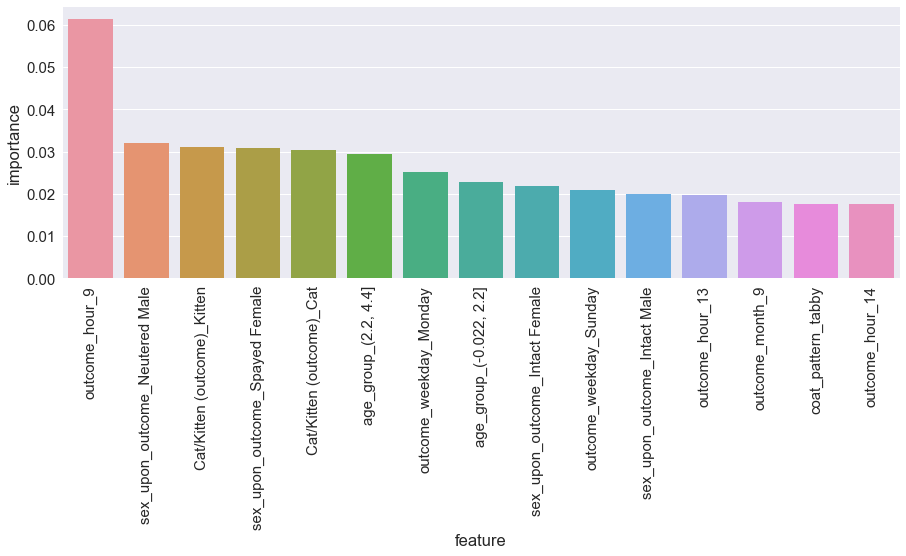

In [17]:
feature_importances = rf_classifier.feature_importances_

importances = pd.DataFrame({'importance': feature_importances, 'feature': xnames}, 
                           index=xnames).sort_values(by='importance', ascending=False)

sns.set(font_scale=1.50)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=importances[0:15])

The random forests classifier reports the most important features when predicting a shelter cat adoption, or partner transfer are:

* The time of outcome is 9 am.
    - To a lesser extent, if the time of day is 8 am, 1 pm or 2 pm appears to somewhat relevant when predicting the adoption or transfer outcome.
    - Monday and Sunday also seem to be significant in predicting the adoption or transfer of a cat.
* The intact status of the cat (spayed/neutered)
* The age of the cat is between 2.2 and 4.4 years old
    - The age group of newborn to 2.2 years also is relatively important in determining the outcome.
    
Do these features as deemed important by the random forest classifier adhere to what we would expect or our previous assumptions? As we are only concerned with the adoption and partner transfer outcomes in this analysis, we would expect the intact status of a cat to be highly important in predicting the outcome as shelters do not adopt cats that are not spayed or neutered. The following are some other expectations given previous assumptions and how they align with the random forest model feature importance.

* Kittenhood is only slightly more important than adult status in predicting the adoption or transfer of the cat. As we saw in the previous notebook the chance of the outcome being an adoption is much higher when the cat is of kitten age than adult age, so it's possible the transfer outcome is more likely when the cat is older.
* The time of day, mainly 9 am, and rounding out the bottom of the top 15 features, 1 pm, 2 pm and 8 am are important to the predictive power of the random forests model. In previous experience, the bulk of adoptions occur early when the shelter is open for adoptions, so the 9 am feature makes sense in this regard. The other times of day could be when the shelter opens later, on the weekend, for example.
* Tabby coat patterns seem to be a comparatively important feature when predicting an adoption or transfer outcome. Tabbies are definitely adorable, but it is interesting how only the tabby coat pattern appear but not any others in the top 15.

## Dimension Reduction with PCA

Principal Component Analysis, better known as PCA, is a dimension reduction technique that is used to reduce the "dimensionality" of data with many dimensions (features, or columns) into a lower dimensional space that retains the amount of explained variance. Reduction of dimensions is often an important step when building a machine learning model as it allows input data to be reduced while still keeping the same amount of information, which helps improve fitting times. For smaller datasets with fewer dimensions, PCA may not be as useful, but in our case, as we are dealing with nearly 300 features, reducing the data by applying a dimension reduction technique could yield several benefits.

PCA is definitely not the only dimension reduction technique in use today but continues to be the most seen due to its relative ease-of-use and fitting time. Here is a quick reference of other [dimension reduction techniques (Wikipedia)](https://en.wikipedia.org/wiki/Dimensionality_reduction).

Principal Component Analysis is implemented in scikit-learn with the [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA) class. Initializing and fitting the PCA class on our training data is similar to fitting the random forest classifier as done previously.

In [18]:
pca = PCA()
pca.fit(x_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

The number of components wasn't specified with the `n_components` parameter. Thus all the components are returned. We can find the number of components returned with the `components_` attribute of the fitted PCA class.

In [19]:
print(len(pca.components_))

283


We can plot the increase in explained variance as the number of components increases. The explained variance reaches about 90% when there are 200 or so components, and approximately 98% when there are 225 components. The number of components needed to explain most of the variance can be of use later when the prediction model is trained.

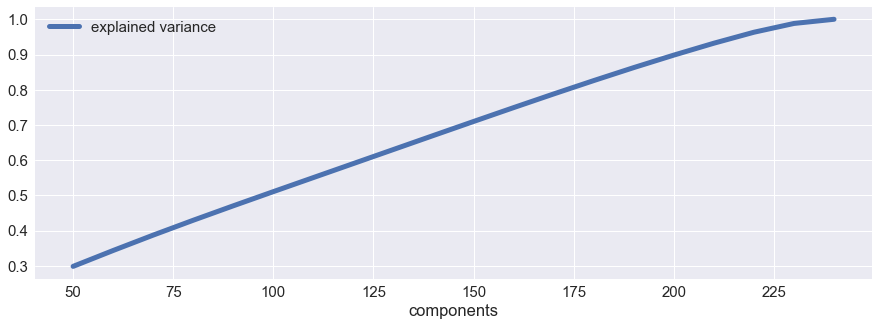

In [20]:
comps = np.arange(50, 250, 10)
exp_var = []

for comp in comps:
    exp_var.append(sum(pca.explained_variance_ratio_[0:comp]))
    
pca_exp_var = pd.concat([pd.Series(comps, name='components'), 
                         pd.Series(exp_var, name='explained variance')], axis=1)

pca_exp_var.set_index('components', inplace=True)

pca_exp_var.plot(kind='line', linewidth=5, figsize=(15, 5))

## Building the Adoption and Transfer Prediction Model

The model for predicting an adoption or transfer of a shelter cat is now ready to be trained with the data prepared and split into training and testing sets. As was possibly foreshadowed earlier in the post, we opt for a Random Forests classifier, which is a meta-estimator that fits multiple decision trees on subsets of the data and averages the performance to improve the model's accuracy and to avoid overfitting. 

The Random Forests model is implemented in scikit-learn in the [ensembles module](http://scikit-learn.org/stable/modules/ensemble.html) as [`RandomForestsClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier). Though we possibly could achieve better prediction power with a different ensemble method, the random forests algorithm is still a robust and often used approach for classification problem such as ours.

To train and test the random forests model, we will take advantage of scikit-learn's [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) which allows us to chain multiple estimators and other preprocessing steps such as dimensionality reduction and feature selection. Pipelines are also invaluable for parameter estimation when tuning the parameters of an estimator or another step in the model.

In addition to performing a dimension reduction technique, applying another feature extraction technique to reduce the amount of data further to be fit but still retaining the most useful features is a good strategy for transforming data that will be used to train a prediction model. To chain multiple dimension reduction techniques similar to the Pipeline class in scikit-learn mentioned previously, we rely on another estimator, [`FeatureUnion`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html#sklearn.pipeline.FeatureUnion), which is used to transform the data and concatenate the results for use with the Pipeline model.

In [21]:
feature_union = FeatureUnion([
    ('pca', PCA()),
    ('kbest', SelectKBest())
])

prediction_model = Pipeline([
    ('feature_union', feature_union),
    ('rf', RandomForestClassifier(n_estimators=1000, criterion='gini', 
                                  class_weight='balanced_subsample', bootstrap=True, 
                                  oob_score=True))
])

In [22]:
prediction_model.fit(x_train_scaled, y_train)

Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x1a102b8378>))],
       transforme...mators=1000, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False))])

The Random Forests model is now fit! We can use the [`predict()`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict) of the fitted model to predict the outcomes using the test data that we created by splitting the original data at the beginning of the notebook.

## Prediction Model Accuracy and Cross-Validation

Cross-validation is another important step in creating and training a prediction model to check and verify how it could potentially perform with new data. At its most basic level, the cross-validation procedure splits the data that was held out into several smaller subsets and fits the model on these subsets. The model is then validated on the remaining data, and the results are averaged into a score.

There are several different types of cross-validation procedures. Here we opt for the [`StratifiedKFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) cross-validation which splits the data further by stratifying it based on the class labels. As one of the outcome classes has only two cases (the Barn outcome), the number of folds is set to two. Otherwise, a warning will be issued.

In [23]:
cv = StratifiedKFold(2)

The [`cross_val_score`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) in scikit-learn performs the cross-validation procedure on the training data and outputs an array of scores of the length of the number of folds. Higher scores are of course desired; however, one should be wary of scores that are very close to $1$ as this could imply overfitting or an issue with the data.

In addition to performing cross-validation on the training data, we also use scikit-learn's [`cross_val_predict`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict) function to cross-validate predictions made against the subsetted data split by the folding.

In [24]:
cv_score = cross_val_score(prediction_model, x_train_scaled, y_train, cv=cv, scoring='accuracy')
cv_predict_score = cross_val_predict(prediction_model, x_train_scaled, y_train, cv=cv)

Print the score array and the mean of the scores, as well as the accuracy score of the cross-validation prediction using the [`accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) function in scikit-learn.

In [25]:
print(cv_score)
print(np.mean(cv_score))

print(accuracy_score(y_train, cv_predict_score))

[0.71984649 0.71835929]
0.7191028902729515
0.7182805132141682


The cross-validation scores are very close to each other at just under 72%! This result is definitely a good start, especially given the problematic nature of the task of determining a cat's outcome upon entering the shelter system with just a few variables. To further test our model's performance, we can use the `predict()` method of the RandomForestClassifier class to test how our model performs on the holdout data that was split from the original data.

In [26]:
rf_pred = prediction_model.predict(x_test_scaled)

Return the accuracy score of the predicted outcomes on the actual outcomes using the `accuracy_score()` function.

In [27]:
print(accuracy_score(y_test, rf_pred))

0.7374952027632083


The accuracy score returned is just under 74%, which is slightly higher than the cross-validated result.

The confusion matrix function that was mentioned at the beginning of the notebook can now be used to produce a more visually appealing confusion matrix which allows us to see how well the model predicted each shelter cat's outcome against the cat's actual outcome.

Normalized confusion matrix
Confusion matrix, without normalization


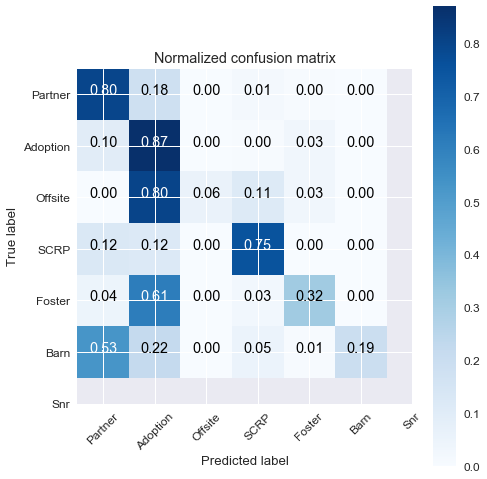

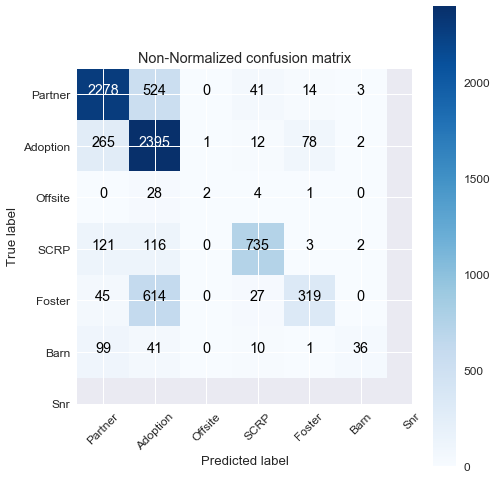

In [28]:
sns.set(font_scale=1.2)

rf_cnf_mat = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(7, 7))
plot_confusion_matrix(rf_cnf_mat, classes=ynames, normalize=True, title='Normalized confusion matrix')

plt.figure(figsize=(7, 7))
plot_confusion_matrix(rf_cnf_mat, classes=ynames, normalize=False, title='Non-Normalized confusion matrix')

plt.show()

Judging from the confusion matrices, we can infer some of the following information:

* The model had the most success in predicting if the cat is to be adopted or transferred to a partner facility, which would make sense as these had the most samples to draw from by far and represent the bulk of the class outcomes. 
* SCRP, a stray animal rescue program, as well as fostering outcomes were also predicted with reasonably well accuracy. 
* There appears to be significant misclassification between a foster outcome and an adoption outcome. We would expect the model to have perhaps some difficulties in determining if an outcome is indeed an adoption or a foster as the difference between the outcomes is very slight. 
  - Many foster situations can also end in permanent adoptions, blurring the lines between the two outcomes even further.
  
A handy table of classification metrics can also be returned with the [`classification_report()`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) function.

In [29]:
print(classification_report(y_test, rf_pred, target_names=ynames))

             precision    recall  f1-score   support

    Partner       0.81      0.80      0.80      2860
   Adoption       0.64      0.87      0.74      2753
    Offsite       0.67      0.06      0.11        35
       SCRP       0.89      0.75      0.81       977
     Foster       0.77      0.32      0.45      1005
       Barn       0.84      0.19      0.31       187

avg / total       0.76      0.74      0.72      7817



## Finding an Optimal Model by Hyperparameter Tuning

We were able to fit a comparatively well-performing random forests classifier model on our first pass, but can the model be tuned to be more efficient, either regarding prediction power, or fitting time, or both? To answer this question, we can perform an exhaustive search of all possible model hyperparameter combinations and compare the results of each fit to see which one is the most performant based on the criteria on which we wish to judge. One way to perform the parameter tuning and searching is to find all possible combinations of the parameters we want to tune and create a function to test all those combinations, or we can use the handy and wonderful [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class provided by scikit-learn for performing the search.

To perform the exhaustive grid search, an estimator, a grid of parameters, a scoring function and a cross-validation method are required. A parameter grid is a set of hyperparameters one wishes to search over the combinations. The parameters we are interested in searching are the number of components returned from a Principal Component Analysis, the number of estimators to use in the random forest model, and the number of features to keep from the [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) function. The "parameter grid" can thus be represented as lists containing the parameter values we wish to search. Note there's no exact science to choosing the parameters to search and it may require a couple of tries to find some decent parameters.

In [32]:
criterion = ['gini', 'entropy']
components = [175, 200, 225]
estimators = [100, 250, 500]
k = [10, 15, 20]

First, we define the Pipeline model we want to use as the estimator during the grid search. The pipeline will be similar to the model we fitted previously. The `param_grid` is required to be a dictionary or a list of dictionaries, and we access the hyperparameters of the model by using a double underscore `__`. We also use scikit-learn's [`OneVsRestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html), which implements a strategy of fitting one classifier per class and is a commonly used strategy for classifying multi-label observations.

In [33]:
feature_union = FeatureUnion([
    ('pca', PCA()),
    ('kbest', SelectKBest())
])

prediction_model_tune = Pipeline([
    ('feature_union', feature_union),
    ('rf', OneVsRestClassifier(RandomForestClassifier(class_weight='balanced_subsample', 
                                                      bootstrap=True, oob_score=True)))
])

rf_gridcv = GridSearchCV(prediction_model_tune, dict(feature_union__pca__n_components=components, 
                                                     feature_union__kbest__k=k, 
                                                     rf__estimator__n_estimators=estimators, 
                                                     rf__estimator__criterion=criterion), 
                         scoring='accuracy', cv=cv, return_train_score=True)

The `GridSearchCV` estimator is then fit as any other scikit-learn model. Note that as the number of parameters and combinations of parameters increases, the amount of time for the search to evaluate all possible combinations grows larger and could take a significant amount of time.

In [34]:
rf_gridcv.fit(x_train_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x1a102b8378>))],
       transforme..., oob_score=True, random_state=None,
            verbose=0, warm_start=False),
          n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'feature_union__pca__n_components': [175, 200, 225], 'feature_union__kbest__k': [10, 15, 20], 'rf__estimator__n_estimators': [100, 250, 500], 'rf__estimator__criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

It is often a good idea to save the fitted model, especially if it is a larger model such as a `GridSearchCV` fit, to avoid having to refit the model each time. There are several ways a scikit-learn model can be saved, one of which is using Python's `pickle` module to store the model. Another way is to use scikit-learn's [`joblib.dump`] function to save the model, which is typically more efficient on large numpy arrays. More information can be found on scikit-learn's documentation on [model persistence](http://scikit-learn.org/stable/modules/model_persistence.html).

In [35]:
joblib.dump(rf_gridcv, '../../data/shelter cats/models/random_forests_grid_model2.pkl') 

['../../data/shelter cats/models/random_forests_grid_model2.pkl']

The results of the grid search are stored in an attribute `cv.results_` that can be easily converted into a pandas DataFrame. The DataFrame is sorted by the rank of the model, and we output the first five rows with `head()`.

In [36]:
results = pd.DataFrame(rf_gridcv.cv_results_)
results.sort_values(by='rank_test_score', ascending=False, inplace=True)
results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_feature_union__kbest__k,param_feature_union__pca__n_components,param_rf__estimator__criterion,param_rf__estimator__n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
12,87.716886,2.666784,0.723051,0.995065,10,225,gini,100,"{'feature_union__kbest__k': 10, 'feature_union...",54,0.725000,0.995832,0.721101,0.994298,0.713797,0.019225,0.001949,0.000767
6,85.200553,2.505491,0.723106,0.995065,10,200,gini,100,"{'feature_union__kbest__k': 10, 'feature_union...",53,0.723794,0.995832,0.722417,0.994298,0.473229,0.005487,0.000688,0.000767
7,211.909958,6.070619,0.723709,0.995065,10,200,gini,250,"{'feature_union__kbest__k': 10, 'feature_union...",52,0.727083,0.995832,0.720333,0.994298,1.021481,0.112463,0.003375,0.000767
30,87.128205,2.666848,0.723928,0.995065,15,225,gini,100,"{'feature_union__kbest__k': 15, 'feature_union...",51,0.726974,0.995832,0.720882,0.994298,0.450901,0.031993,0.003046,0.000767
14,430.561303,12.561810,0.724147,0.995065,10,225,gini,500,"{'feature_union__kbest__k': 10, 'feature_union...",50,0.726864,0.995832,0.721430,0.994298,6.964933,0.287931,0.002717,0.000767


The best model of all possible combinations of the grid search that was performed reported a cross-validated accuracy of approximately 72%, which is slightly higher than the first model that was fit earlier in the notebook. The best parameter combination according to the grid search results is:

* `k = 10` in `SelectKBest()`
* `n_components = 225` in `PCA()`
* The Random Forests criterion for splitting the nodes of the trees is `'gini'`
* 100 estimators in the random forest model is sufficient.

Our first model used the default k = 10, kept all 283 components from the PCA and used 1,000 estimators, so we can see that using the new parameters should likely yield a better fitting time while also granting slightly improved accuracy. The mean training time is also about 1 minute and 28 seconds, though this was ran on an older MacBook Pro 2011 on one core, so this is not very indicative of timing on a newer machine with a faster CPU utilizing several cores. 

As with the first model, we can print a confusion matrix of the predicted results on the held out test data to see how well the model classifies each outcome observation. The returned fitted object from `GridSearchCV` automatically uses the most performant model when using the `predict()` method.

Normalized confusion matrix


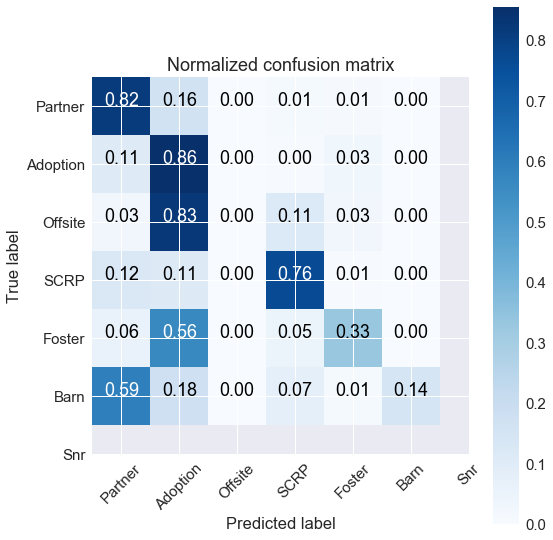

In [37]:
sns.set(font_scale=1.5)

rf_grid_pred = rf_gridcv.predict(x_test_scaled)
rf_cnf_mat = confusion_matrix(y_test, rf_grid_pred)

plt.figure(figsize=(8, 8))

plot_confusion_matrix(rf_cnf_mat, classes=ynames, normalize=True, title='Normalized confusion matrix')

The confusion matrix shows similar results to the original model, though the misclassification of Adoptions and Offsite outcomes appears to have increased slightly. As before, print the accuracy score of the predicted values on the held out test set.

In [38]:
print(accuracy_score(y_test, rf_grid_pred))

0.7419726237687092


The prediction accuracy of the new model found from the grid search is just over 74%, which is about a 2% absolute increase in accuracy compared to our first model. Therefore, we see the model returned by the parameter search is more performant than the original in regards to cross-validated results but requires fewer estimators and fewer components kept from the PCA preprocessing step which leads to a shorter fitting time.

## Conclusion

By leveraging machine learning models and other data transformation techniques, we were able to identify several important features that help predict a shelter cat's adoption or transfer outcome as well as fit a decently accurate prediction model that can be used for future cases. Of course, we could continue to refine the model by testing more hyperparameter combinations and also trying different feature selection and data transformation processes, as well as various ensemble methods.

The first two notebooks in the series can also be found below:

* [Extraction and Feature Engineering of Animal Austin Center's Shelter Outcomes](https://aaronschlegel.me/extraction-feature-engineering-aac-data-requests-pandas.html)
* [Exploratory Data Analysis of Shelter Cat Outcomes](https://aaronschlegel.me/exploratory-data-analysis-shelter-cat-outcomes-pandas-seaborn.html)